In [124]:
import os, glob

import matplotlib.pyplot as plt

from astropy.nddata import CCDData
from astropy.wcs import WCS
from photutils.aperture import SkyCircularAperture, CircularAperture, aperture_photometry
from photutils.segmentation import detect_sources, make_2dgaussian_kernel
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import vstack
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve

import ccdproc

from util import *

# Extract the Signal

In [63]:
wcs_data_path = os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "calib", "*WCS*")
wcs_data_files = glob.glob(wcs_data_path)
wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]
for ii, d in enumerate(wcs_data):
    d.mask = np.isnan(d.data)
    wcs_data[ii] = d
        

In [67]:
pos = SkyCoord(
    "05:26:38.320",
    "-17:54:54.68",
    unit=("hourangle", "deg")
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)
apertures = [aperture.to_pixel(d.wcs) for d in wcs_data]

res = {v[0].meta["FILTER"]: aperture_photometry(*v) for v in zip(wcs_data, apertures)}

res

{'Harris-R': <QTable length=1>
   id       xcenter          ycenter         aperture_sum  
              pix              pix               adu       
 int64      float64          float64           float64     
 ----- ----------------- ---------------- -----------------
     1 689.1902316237959 705.135713586497 531131.4427429417,
 'Harris-B': <QTable length=1>
   id       xcenter           ycenter         aperture_sum  
              pix               pix               adu       
 int64      float64           float64           float64     
 ----- ----------------- ----------------- -----------------
     1 692.4297288520879 704.3353420770002 343480.7619867225,
 'Harris-V': <QTable length=1>
   id       xcenter           ycenter         aperture_sum   
              pix               pix               adu        
 int64      float64           float64           float64      
 ----- ----------------- ----------------- ------------------
     1 686.6747350069558 707.9193545467556 499030.46

In [68]:
apertures

[<CircularAperture([689.19023162, 705.13571359], r=11.764050943694759)>,
 <CircularAperture([692.42972885, 704.33534208], r=11.773528521185607)>,
 <CircularAperture([686.67473501, 707.91935455], r=11.75836661478643)>,
 <CircularAperture([691.20742002, 709.6860327 ], r=11.766705413868495)>]

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


Text(0.5, 0.01, 'Right Ascension')

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


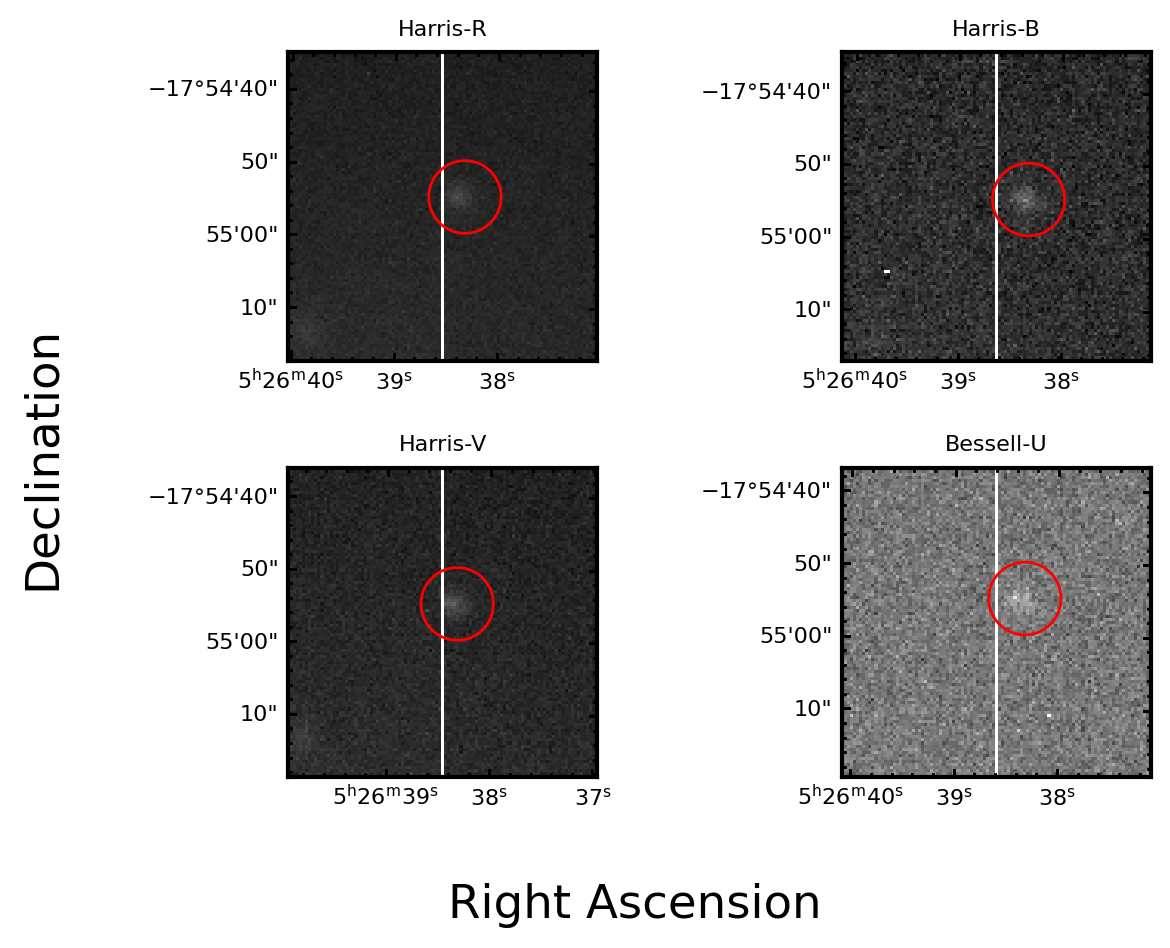

In [69]:
from matplotlib.colors import Normalize as Normalizer
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import simple_norm

fs = 8
ms = 500
fig = plt.figure()

norm_kwargs = { # these are all from playing around in ds9
    "Harris-B" : dict(vmin=775, vmax=930),
    "Harris-R" : dict(vmin=1175, vmax=1787),
    "Harris-V" : dict(vmin=1140, vmax=1532),
    "Bessell-U" : dict(vmin=186, vmax=252)
}

for ii, (img, a) in enumerate(zip(wcs_data, apertures)):

    wcs = img.wcs
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    
    aper = a.to_sky(wcs)
    print(aper.positions)
    
    circ = SphericalCircle(aper.positions, aper.r, edgecolor='red', facecolor='none', transform=ax.get_transform('fk5'))
    ax.add_patch(circ)
    
    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
    
    # ax.scatter_coord(pos, ms, edgecolor='r', facecolor="none")
    
    ax.set_title(img.meta["FILTER"], fontsize=fs)
    
    dx = dy = 50
    midx = img.data.shape[0]//2
    midy = img.data.shape[0]//2 + 20
    xlim = (midx-dx, midx+dx)
    ylim = (midy-dy, midy+dy)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
fig.supylabel("Declination")
fig.supxlabel("Right Ascension")

In [80]:
gain = 3.1 * u.electron/u.adu
electron_to_photons = 1 *u.photon/u.electron

res_to_stack = []
for k, row in res.items():
    row["FILTER"] = k
    row["aperture_sum_e"] = row["aperture_sum"] * gain
    row["aperture_sum_photons"] = row["aperture_sum_e"] * electron_to_photons
    
    res_to_stack.append(row)
    
vstack(res_to_stack)

id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons
,pix,pix,adu,,electron,ph
int64,float64,float64,float64,str9,float64,float64
1,689.1902316237959,705.135713586497,531131.4427429417,Harris-R,1646507.4725031191,1646507.4725031191
1,692.4297288520879,704.3353420770002,343480.7619867225,Harris-B,1064790.3621588396,1064790.3621588396
1,686.6747350069558,707.9193545467556,499030.46997269196,Harris-V,1546994.456915345,1546994.456915345
1,691.2074200169961,709.6860327014286,91932.60757512719,Bessell-U,284991.0834828943,284991.0834828943


# Sky Background Noise

Put a bunch of apertures on the background of the images and median them

In [101]:
def find_background(img, n=100, radius=5):
    
    bckgd_apertures = [
        CircularAperture(
            (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1])), 
            radius
        )
        for _ in range(n)
    ]       
    res = vstack([aperture_photometry(img, a) for a in bckgd_apertures])
    return np.median(res["aperture_sum"])
    
for img in wcs_data:
    print(find_background(img))
    

102576.99618159176 adu
64169.83503790152 adu
95380.76736994676 adu
17140.175633002527 adu


<photutils.segmentation.core.SegmentationImage>
shape: (1365, 1365)
nlabels: 1
labels: [1]


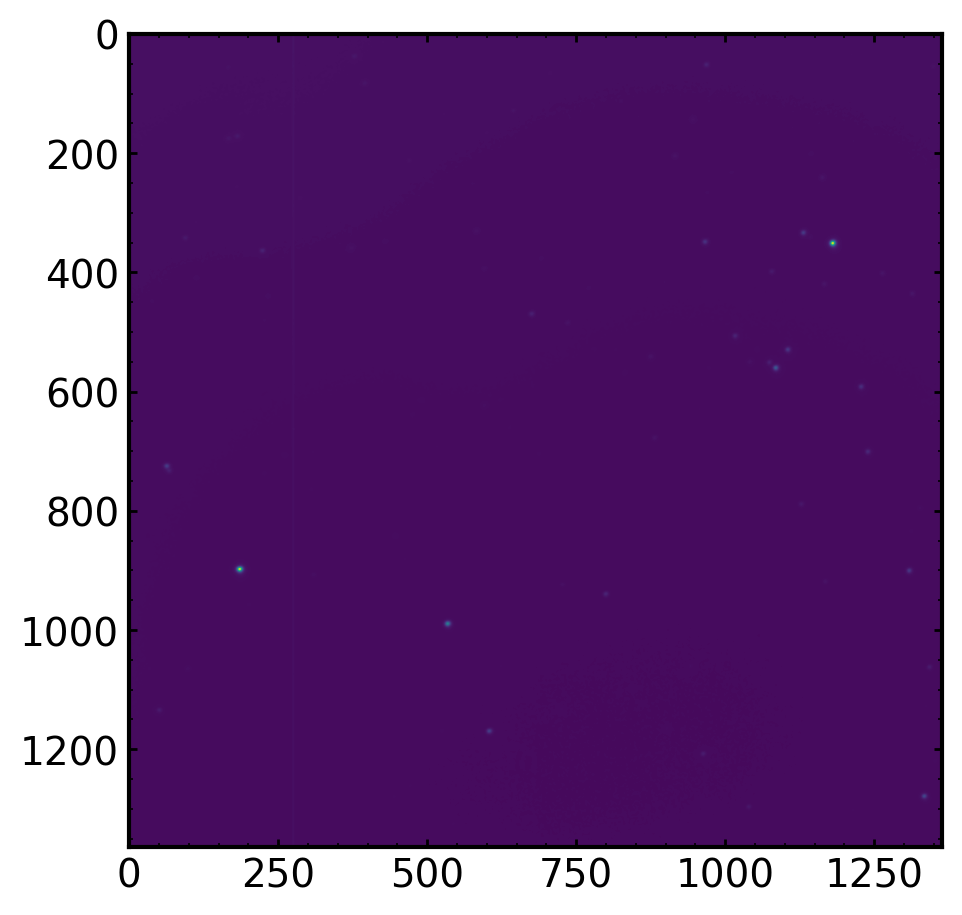

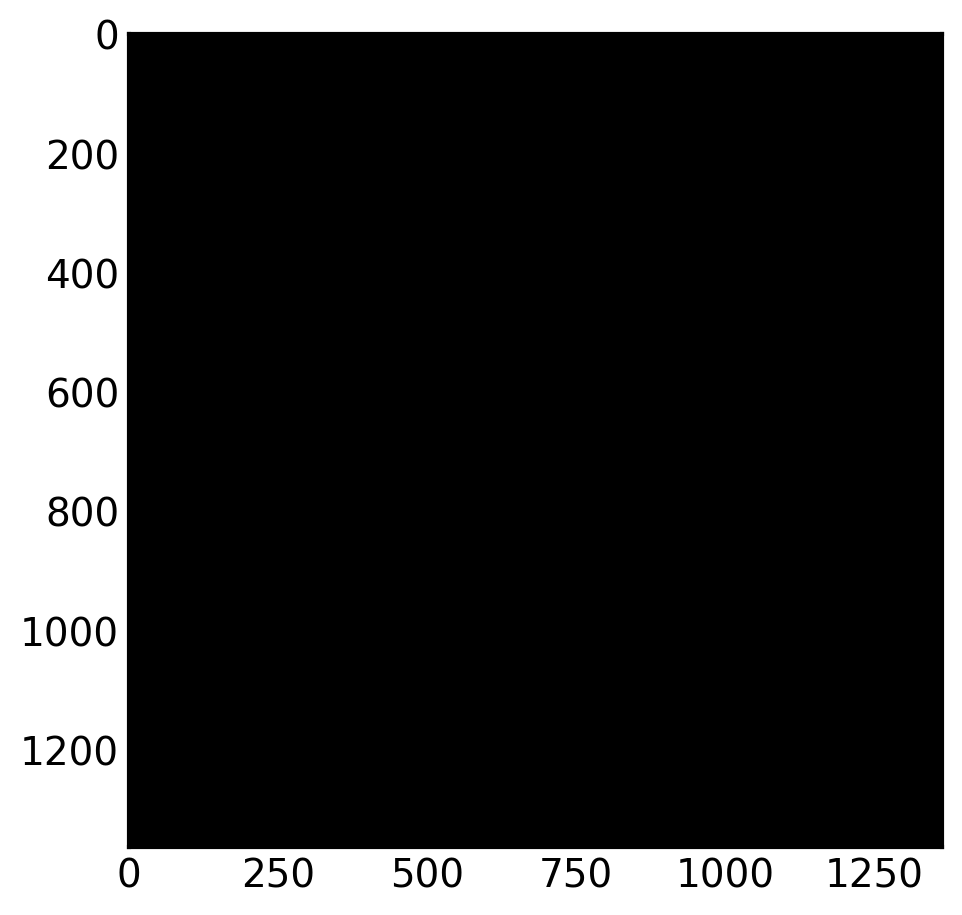

In [151]:
for img in wcs_data:
    mean, _, std = sigma_clipped_stats(img)
    
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.
    convolved_data = convolve(img.data, kernel)
    plt.imshow(convolved_data)
    seg_img = detect_sources(convolved_data, threshold=1, npixels=3)
    print(seg_img)
    plt.figure()
    plt.imshow(seg_img.data, cmap=seg_img.make_cmap(seed=1234))
    
    break

In [131]:
seg_img

<photutils.segmentation.core.SegmentationImage>
shape: (1365, 1365)
nlabels: 1
labels: [1]